In [1]:
import torch
import torchvision
import torch.optim as optim
from torch.utils.data import DataLoader
import numpy as np
from sklearn.model_selection import train_test_split as tts
import os
import pickle
import importlib

import datasets
importlib.reload(datasets)
from datasets import DatasetGenerator, PairedMNISTDataset

import helpers
importlib.reload(helpers)
from helpers import EarlyStopper, classification_run, contrastive_run, unet_run, run_dswd_classwise, run_dswd_all_classes

from models import TinyCNN, TinyCNN_Headless, TinyCNN_Head, WrapperModelTrainHead, CustomUNET

In [2]:
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

In [3]:
mnist_train = torchvision.datasets.MNIST(root='./data', train=True, download=True)
mnist_test = torchvision.datasets.MNIST(root='./data', train=False, download=True)

x_train = mnist_train.data.numpy()
y_train = mnist_train.targets.numpy()

x_test = mnist_test.data.numpy()
y_test = mnist_test.targets.numpy()

x_test, x_val, y_test, y_val = tts(
    x_test, y_test, test_size=.5, random_state=71
)

## Base - None / Aux - Gap

In [5]:
base = "skip"
aux = "none"

In [6]:
train_ds_gen: DatasetGenerator = DatasetGenerator(
    images = x_train,
    labels = y_train,
    subset_ratio = .2,
    base_ds=base,
    aux_ds=aux
)

base_images_train, base_labels_train = train_ds_gen.build_base_dataset()
aux_images_train, aux_labels_train = train_ds_gen.build_aux_dataset()

print(f"Train Dataset Base Size: {len(base_images_train)}")
print(f"Train Dataset Aux Size: {len(aux_images_train)}")

test_ds_gen: DatasetGenerator = DatasetGenerator(
    images = x_test,
    labels = y_test,
    subset_ratio = .5,
    base_ds=base,
    aux_ds=aux
)

base_images_test, base_labels_test = test_ds_gen.build_base_dataset()
aux_images_test, aux_labels_test = test_ds_gen.build_aux_dataset()

print(f"Test Dataset Base Size: {len(base_images_test)}")
print(f"Test Dataset Aux Size: {len(aux_images_test)}")

val_ds_gen: DatasetGenerator = DatasetGenerator(
    images = x_val,
    labels = y_val,
    subset_ratio = .5,
    base_ds=base,
    aux_ds=aux
)

base_images_val, base_labels_val = val_ds_gen.build_base_dataset()
aux_images_val, aux_labels_val = val_ds_gen.build_aux_dataset()

print(f"Validation Dataset Base Size: {len(base_images_val)}")
print(f"Validation Dataset Aux Size: {len(aux_images_val)}")


Train Dataset Base Size: 12000
Train Dataset Aux Size: 48000
Test Dataset Base Size: 2500
Test Dataset Aux Size: 2500
Validation Dataset Base Size: 2500
Validation Dataset Aux Size: 2500


In [7]:
train_dataset: PairedMNISTDataset = PairedMNISTDataset(
    base_images=base_images_train,
    base_labels=base_labels_train,
    aux_images=aux_images_train,
    aux_labels=aux_labels_train
)

test_dataset: PairedMNISTDataset = PairedMNISTDataset(
    base_images=base_images_test,
    base_labels=base_labels_test,
    aux_images=aux_images_test,
    aux_labels=aux_labels_test
)

val_dataset: PairedMNISTDataset = PairedMNISTDataset(
    base_images=base_images_val,
    base_labels=base_labels_val,
    aux_images=aux_images_val,
    aux_labels=aux_labels_val
)

train_loader: DataLoader = DataLoader(
    dataset=train_dataset,
    batch_size=64,
    shuffle=True,
    drop_last=True
)

test_loader: DataLoader = DataLoader(
    dataset=test_dataset,
    batch_size=64,
    drop_last=True
)

val_loader: DataLoader = DataLoader(
    dataset=val_dataset,
    batch_size=64,
    drop_last=True
)

In [8]:
if not os.path.exists("unet_folder"):
    os.mkdir("unet_folder")

### Base Model Training

In [9]:
if not os.path.exists(f"unet_folder/base_classifier_{base}.pt"):
    num_base_epochs = 20

    model = TinyCNN()
    model.to(DEVICE)
    optimizer = optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-5)
    base_early_stopper = EarlyStopper(
        patience=5,
        min_delta=0
    )

    base_best = {
        "val_loss": 1000,
        "val_acc": 0
    }

    for epoch in range(num_base_epochs):
        train_loss, train_acc = classification_run(
            model=model,
            optimizer=optimizer,
            dataloader=train_loader,
            mode="base_only",
            device=DEVICE,
        )

        val_loss, val_acc = classification_run(
            model=model,
            optimizer=optimizer,
            dataloader=val_loader,
            mode="base_only",
            device=DEVICE,
            train=False
        )

        print(f"Epoch {epoch+1}:", round(train_loss, 4), round(train_acc*100, 2), round(val_loss, 4), round(val_acc*100, 2))

        if val_loss < base_best["val_loss"]:
            base_best["val_loss"] = val_loss
            base_best["val_acc"] = val_acc
            torch.save(model.state_dict(), f"unet_folder/base_classifier_{base}.pt")

        if base_early_stopper(val_loss):
            print("Stopped")
            break

Epoch 1: 1.1469 61.36 0.5881 80.85
Epoch 2: 0.5159 83.51 0.4131 86.82
Epoch 3: 0.3756 88.13 0.3267 88.34
Epoch 4: 0.3053 90.17 0.2653 90.87
Epoch 5: 0.2708 91.29 0.2707 90.87
Epoch 6: 0.2421 92.29 0.2224 92.47
Epoch 7: 0.2229 92.95 0.2062 93.15
Epoch 8: 0.2107 93.24 0.2017 93.11
Epoch 9: 0.2032 93.41 0.2037 93.03
Epoch 10: 0.193 93.88 0.2054 92.87
Epoch 11: 0.1773 94.12 0.2036 93.59
Epoch 12: 0.1678 94.68 0.1885 94.15
Epoch 13: 0.1652 94.62 0.1831 94.23
Epoch 14: 0.1572 94.83 0.2075 93.39
Epoch 15: 0.1468 95.45 0.1806 94.83
Epoch 16: 0.1409 95.26 0.174 94.79
Epoch 17: 0.1366 95.57 0.1734 94.75
Epoch 18: 0.1239 95.88 0.1798 94.63
Epoch 19: 0.1223 95.94 0.185 94.31
Epoch 20: 0.1134 96.19 0.189 94.27


### Mixed Model Training

In [10]:
if not os.path.exists(f"unet_folder/mixed_classifier_{base}+{aux}.pt"):
    model = TinyCNN()
    model.to(DEVICE)
    optimizer = optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-5)
    base_early_stopper = EarlyStopper(
        patience=5,
        min_delta=0
    )

    base_aux_best = {
        "val_loss": 1000,
        "val_acc": 0
    }

    for epoch in range(num_base_epochs):
        train_loss, train_acc = classification_run(
            model=model,
            optimizer=optimizer,
            dataloader=train_loader,
            mode="base_and_aux",
            device=DEVICE,
        )

        val_loss, val_acc = classification_run(
            model=model,
            optimizer=optimizer,
            dataloader=val_loader,
            device=DEVICE,
            mode="base_only",
            train=False
        )

        print(f"Epoch {epoch+1}:", round(train_loss, 4), round(train_acc*100, 2), round(val_loss, 4), round(val_acc*100, 2))

        if val_loss < base_aux_best["val_loss"]:
            base_aux_best["val_loss"] = val_loss
            base_aux_best["val_acc"] = val_acc
            torch.save(model.state_dict(), f"unet_folder/mixed_classifier_{base}+{aux}.pt")

        if base_early_stopper(val_loss):
            print("Stopped")
            break


Epoch 1: 1.0509 65.19 0.5614 81.49
Epoch 2: 0.3895 88.08 0.3756 87.78
Epoch 3: 0.2768 91.44 0.2808 90.95
Epoch 4: 0.2198 93.11 0.2688 90.38
Epoch 5: 0.1995 93.76 0.2474 91.31
Epoch 6: 0.1678 94.67 0.2183 92.67
Epoch 7: 0.1593 95.02 0.2206 92.95
Epoch 8: 0.1484 95.35 0.1933 93.79
Epoch 9: 0.1418 95.46 0.2104 93.15
Epoch 10: 0.1331 95.71 0.1996 93.11
Epoch 11: 0.1358 95.75 0.1809 94.23
Epoch 12: 0.1189 96.11 0.184 94.23
Epoch 13: 0.1184 96.22 0.2023 93.03
Epoch 14: 0.1168 96.37 0.1886 93.99
Epoch 15: 0.109 96.46 0.1807 94.15
Epoch 16: 0.1026 96.67 0.1697 94.35
Epoch 17: 0.1031 96.82 0.1814 94.19
Epoch 18: 0.1003 96.82 0.1798 94.27
Epoch 19: 0.0916 97.21 0.1719 94.47
Epoch 20: 0.0914 96.99 0.1939 93.23


### Supervised Contrastive Learning Model

#### Body Training + Temperature Hyperparameter Selection

In [11]:
num_contrast_epochs = 200
temp_range = np.linspace(0.05, .15, 3)
best_val_loss = 1000*np.ones(len(temp_range))

for i, temp in enumerate(temp_range):
    model = TinyCNN_Headless()
    proj_head = torch.nn.Linear(32, 128)

    model.to(DEVICE)
    proj_head.to(DEVICE)

    contrast_optimizer = optim.Adam(
        list(model.parameters()) + list(proj_head.parameters()),
        lr=0.001, 
        weight_decay=1e-5
    )

    contrast_early_stopper = EarlyStopper(
        patience=10,
        min_delta=0
    )

    for epoch in range(num_contrast_epochs):
        train_loss = contrastive_run(
            model=model,
            proj_head=proj_head,
            optimizer=contrast_optimizer,
            dataloader=train_loader,
            device=DEVICE,
            temperature=temp
        )

        val_loss = contrastive_run(
            model=model,
            proj_head=proj_head,
            optimizer=contrast_optimizer,
            dataloader=val_loader,
            device=DEVICE,
            train=False,
            temperature=temp
        )

        if val_loss < best_val_loss[i]:
            best_val_loss[i] = val_loss
            torch.save(model.state_dict(), f"unet_folder/contrast_body_{base}+{aux}_{round(temp, 2)}.pt")
            torch.save(proj_head.state_dict(), f"unet_folder/contrast_proj_{base}+{aux}_{round(temp, 2)}.pt")

        if contrast_early_stopper(val_loss):
            print("\n")
            print(f"Best Val Loss ({round(temp, 2)}):", best_val_loss[i])
            break

        if (epoch+1 == num_contrast_epochs):
            print("\n")
            print(f"Best Val Loss ({round(temp, 2)}):", best_val_loss[i])



Best Val Loss (0.05): 2.76558309334975


Best Val Loss (0.1): 2.769860640550271


Best Val Loss (0.15): 2.770813727990175


#### Supervised Contrastive Learning Head Training

In [12]:
best_temp = round(temp_range[np.argmin(best_val_loss)], 2)
print(f"Best temp: {best_temp}")

Best temp: 0.05


In [13]:
num_class_epochs = 20

contrast_body = TinyCNN_Headless()
contrast_body.load_state_dict(torch.load(f"unet_folder/contrast_body_{base}+{aux}_{best_temp}.pt", weights_only=True))

class_head = TinyCNN_Head()

wrapped_model = WrapperModelTrainHead(
    body = contrast_body,
    head = class_head
)
wrapped_model.to(DEVICE)
optimizer = optim.Adam(
    wrapped_model.head.parameters(),
    lr = 0.001,
    weight_decay = 1e-5
)

contrast_early_stopper = EarlyStopper(
    patience=5,
    min_delta=0
)

contrast_best = {
    "val_loss": 1000,
    "val_acc": 0
}

for epoch in range(num_class_epochs):
    train_loss, train_acc = classification_run(
        model=wrapped_model,
        optimizer=optimizer,
        dataloader=train_loader,
        mode="base_and_aux",
        device=DEVICE,
    )

    val_loss, val_acc = classification_run(
        model=wrapped_model,
        optimizer=optimizer,
        dataloader=val_loader,
        device=DEVICE,
        mode="base_only",
        train=False
    )

    print(f"Epoch {epoch+1}:", round(train_loss, 4), round(train_acc*100, 2), round(val_loss, 4), round(val_acc*100, 2))

    if val_loss < contrast_best["val_loss"]:
        contrast_best["val_loss"] = val_loss
        contrast_best["val_acc"] = val_acc
        torch.save(wrapped_model.state_dict(), f"unet_folder/contrast_classifier_{base}+{aux}.pt")

    if contrast_early_stopper(val_loss):
        print("\n")
        print("Best Val Loss:", contrast_best["val_loss"])
        print("Best Val Acc:", round(contrast_best["val_acc"]*100, 2))
        break

    if (epoch+1 == num_class_epochs):
        print("\n")
        print("Best Val Loss:", contrast_best["val_loss"])
        print("Best Val Acc:", round(contrast_best["val_acc"]*100, 2))

Epoch 1: 1.9407 70.42 1.533 92.59
Epoch 2: 0.7869 97.03 0.6316 94.67
Epoch 3: 0.3119 97.58 0.3624 95.23
Epoch 4: 0.1877 97.76 0.2638 95.51
Epoch 5: 0.1414 97.89 0.2152 95.47
Epoch 6: 0.1156 97.97 0.1895 95.59
Epoch 7: 0.0973 97.97 0.1738 95.39
Epoch 8: 0.0923 98.09 0.1641 95.39
Epoch 9: 0.0823 98.28 0.1565 95.59
Epoch 10: 0.0793 98.08 0.1508 95.67
Epoch 11: 0.078 98.17 0.1482 95.67
Epoch 12: 0.0723 98.22 0.1449 95.67
Epoch 13: 0.07 98.29 0.1446 95.67
Epoch 14: 0.063 98.47 0.1427 95.71
Epoch 15: 0.0633 98.37 0.1422 95.63
Epoch 16: 0.0614 98.45 0.1408 95.63
Epoch 17: 0.0619 98.37 0.1408 95.67
Epoch 18: 0.0597 98.42 0.1418 95.67
Epoch 19: 0.0568 98.5 0.1403 95.71
Epoch 20: 0.0622 98.33 0.1401 95.67


Best Val Loss: 0.14012822432395738
Best Val Acc: 95.67


### Compare Accuracies Between Models

In [14]:
base_model = TinyCNN()
base_model.load_state_dict(torch.load(f"unet_folder/base_classifier_{base}.pt", weights_only=True))
base_model.to(DEVICE)
base_loss, base_acc = classification_run(
    model=base_model,
    optimizer=optimizer,
    dataloader=val_loader,
    device=DEVICE,
    mode="base_only",
    train=False
)

mixed_model = TinyCNN()
mixed_model.load_state_dict(torch.load(f"unet_folder/mixed_classifier_{base}+{aux}.pt", weights_only=True))
mixed_model.to(DEVICE)
mixed_loss, mixed_acc = classification_run(
    model=mixed_model,
    optimizer=optimizer,
    dataloader=val_loader,
    device=DEVICE,
    mode="base_only",
    train=False
)


contrast_body = TinyCNN_Headless()
contrast_head = TinyCNN_Head()

contrast_model = WrapperModelTrainHead(
    body=contrast_body,
    head=contrast_head
)
contrast_model.load_state_dict(torch.load(f"unet_folder/contrast_classifier_{base}+{aux}.pt", weights_only=True))
contrast_model.to(DEVICE)

contrast_loss, contrast_acc = classification_run(
    model=contrast_model,
    optimizer=optimizer,
    dataloader=val_loader,
    device=DEVICE,
    mode="base_only",
    train=False
)

print(f"Base: {round(base_loss, 4)}, {round(base_acc*100, 2)}")
print(f"Base + Aux: {round(mixed_loss, 4)}, {round(mixed_acc*100, 2)}")
print(f"Base + Aux: {round(contrast_loss, 4)}, {round(contrast_acc*100, 2)}")

Base: 0.1734, 94.75
Base + Aux: 0.1697, 94.35
Base + Aux: 0.1401, 95.67


### Plot Latent Space Representations

In [15]:
base_model = TinyCNN()
base_model.load_state_dict(torch.load(f"unet_folder/base_classifier_{base}.pt", weights_only=True))
base_model.eval()

mixed_model = TinyCNN()
mixed_model.load_state_dict(torch.load(f"unet_folder/mixed_classifier_{base}+{aux}.pt", weights_only=True))
mixed_model.eval()

contrast_body = TinyCNN_Headless()
contrast_head = TinyCNN_Head()

contrast_model = WrapperModelTrainHead(
    body=contrast_body,
    head=contrast_head
)

contrast_model.load_state_dict(torch.load(f"unet_folder/contrast_classifier_{base}+{aux}.pt", weights_only=True))
contrast_model.eval()

contrast_model.to(DEVICE)
base_model.to(DEVICE)
mixed_model.to(DEVICE)

base_embeds = np.zeros((len(test_dataset), 32))
mixed_embeds_base = np.zeros((len(test_dataset), 32))
mixed_embeds_aux = np.zeros((len(test_dataset), 32))
contrast_embeds_base = np.zeros((len(test_dataset), 32))
contrast_embeds_aux = np.zeros((len(test_dataset), 32))
labels = np.zeros(len(test_dataset))

test_loader.dataset.unique_sources = True
bs = val_loader.batch_size

for i, (x,y,z) in enumerate(test_loader):
    x = x.to(DEVICE)
    y = y.to(DEVICE)
    with torch.no_grad():
        base_outputs = base_model(x)[9].cpu().numpy()
        mixed_outputs_base = mixed_model(x)[9].cpu().numpy()
        mixed_outputs_aux = mixed_model(y)[9].cpu().numpy()
        contrast_outputs_base = contrast_model(x)[9].cpu().numpy()
        contrast_outputs_aux = contrast_model(y)[9].cpu().numpy()

        base_embeds[i*bs:i*bs+bs] = base_outputs
        mixed_embeds_base[i*bs:i*bs+bs] = mixed_outputs_base
        mixed_embeds_aux[i*bs:i*bs+bs] = mixed_outputs_aux
        contrast_embeds_base[i*bs:i*bs+bs] = contrast_outputs_base
        contrast_embeds_aux[i*bs:i*bs+bs] = contrast_outputs_aux
        labels[i*bs:i*bs+bs] = z.cpu()


C:\Users\Justin\AppData\Local\Temp\ipykernel_32724\2484856803.py:51: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  tab20 = plt.cm.get_cmap('tab20')
C:\Users\Justin\AppData\Local\Temp\ipykernel_32724\2484856803.py:86: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  tab20 = plt.cm.get_cmap('tab20')


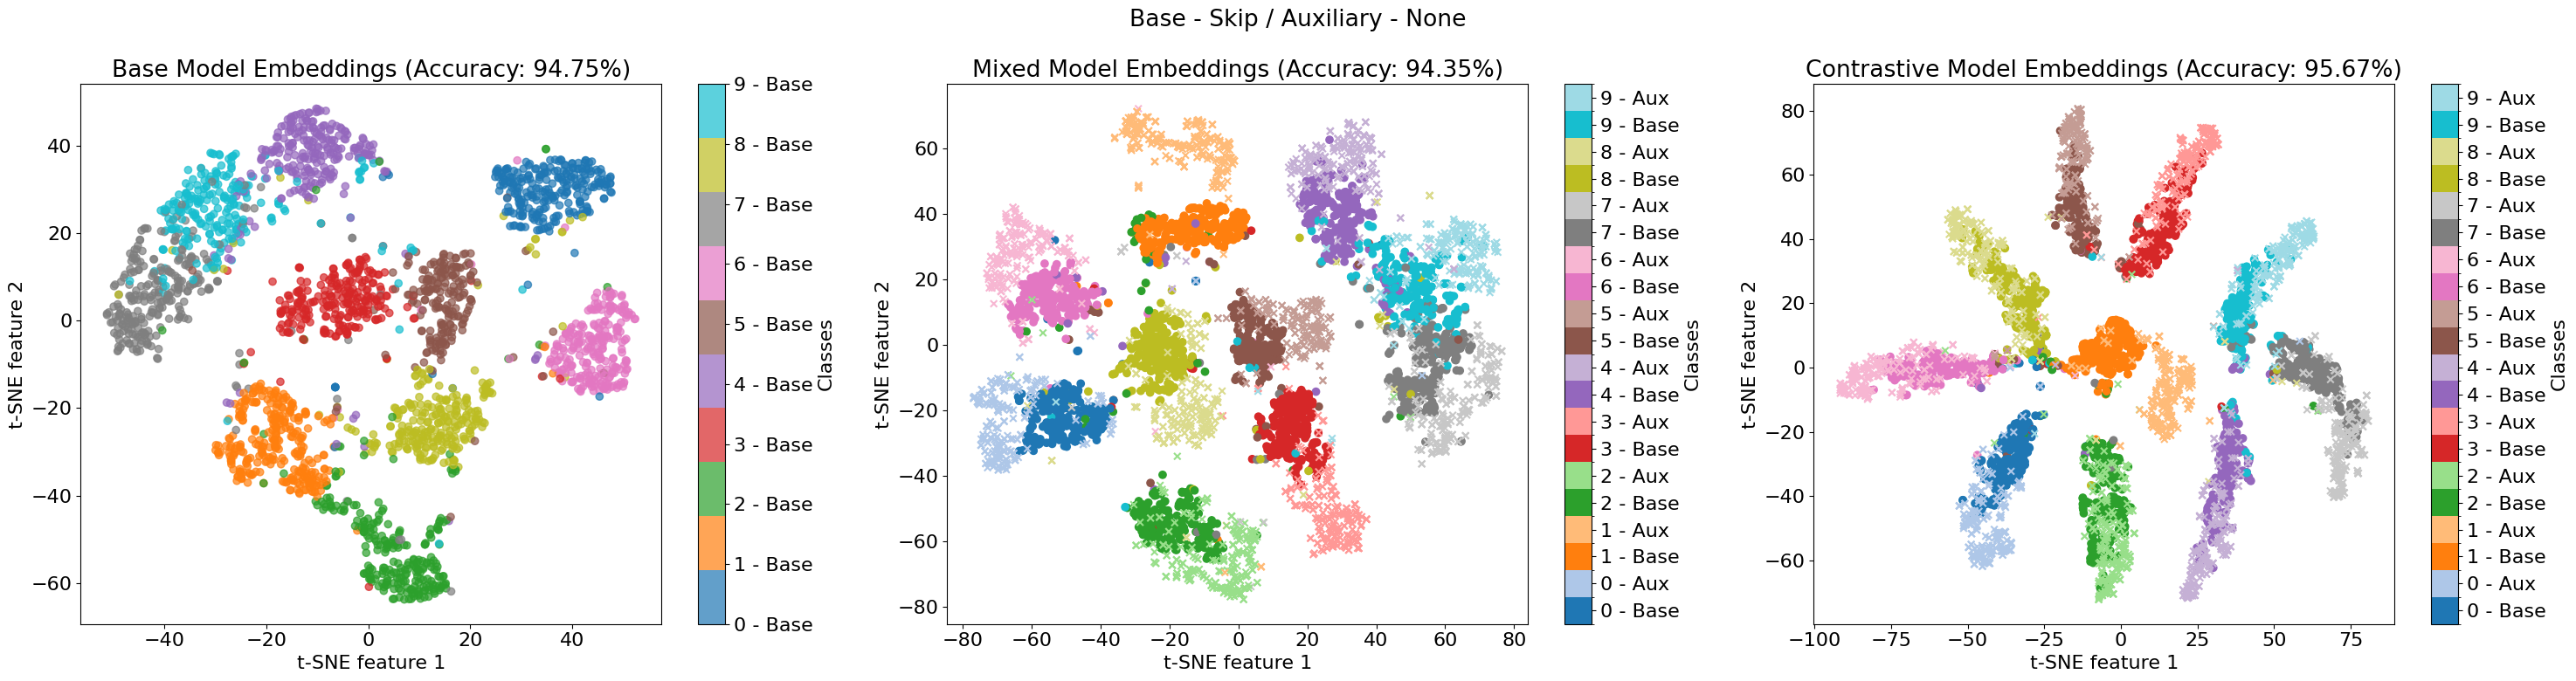

In [16]:
mixed_labels = np.concatenate((labels*2, labels*2+1))
mixed_embeds = np.concatenate((mixed_embeds_base, mixed_embeds_aux))

contrast_labels = np.concatenate((labels*2, labels*2+1))
contrast_embeds = np.concatenate((contrast_embeds_base, contrast_embeds_aux))

import numpy as np
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import matplotlib.colors as mcolors

plt.rcParams['font.size'] = 16

# Perform t-SNE for all three embedding sets
tsne = TSNE(n_components=2, random_state=42)
base_tsne = tsne.fit_transform(base_embeds)
mixed_tsne = tsne.fit_transform(mixed_embeds)
contrast_tsne = tsne.fit_transform(contrast_embeds)

# Convert labels to numpy if it's a torch tensor
if isinstance(labels, torch.Tensor):
    labels = labels.numpy()

# Create three subplots side by side
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(30, 8))

# Plot for base embeddings
scatter1 = ax1.scatter(base_tsne[:, 0], base_tsne[:, 1], c=labels, cmap='tab10', alpha=.7)
ax1.set_title(f'Base Model Embeddings (Accuracy: {round(base_acc*100, 2)}%)')
ax1.set_xlabel('t-SNE feature 1')
ax1.set_ylabel('t-SNE feature 2')
cbar = fig.colorbar(scatter1, ax=ax1)
ticks = np.arange(0, 10)
c_labels = [ 
    "0 - Base",
    "1 - Base",
    "2 - Base",
    "3 - Base",
    "4 - Base",
    "5 - Base",
    "6 - Base",
    "7 - Base",
    "8 - Base",
    "9 - Base",
]
cbar.set_ticks(ticks)
cbar.set_ticklabels(c_labels)
cbar.set_label("Classes")

tab20 = plt.cm.get_cmap('tab20')
color_dict = {i: tab20(i/20) for i in range(20)}

scatter2a = ax2.scatter(mixed_tsne[:len(mixed_tsne)//2, 0], mixed_tsne[:len(mixed_tsne)//2, 1], c=[color_dict[label] for label in mixed_labels[:len(mixed_tsne)//2]])
scatter2b = ax2.scatter(mixed_tsne[len(mixed_tsne)//2:, 0], mixed_tsne[len(mixed_tsne)//2:, 1], c=[color_dict[label] for label in mixed_labels[len(mixed_tsne)//2:]], marker="x", s=30)
ax2.set_title(f'Mixed Model Embeddings (Accuracy: {round(mixed_acc*100, 2)}%)')
ax2.set_xlabel('t-SNE feature 1')
ax2.set_ylabel('t-SNE feature 2')
colors = [color_dict[i] for i in range(20)]
cmap = mcolors.ListedColormap(colors)
bounds = np.arange(21)
norm = mcolors.BoundaryNorm(bounds, cmap.N)

# Create the colorbar
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])
cbar = fig.colorbar(sm, ax=ax2, ticks=np.arange(0.5, 20))

c_labels = [
    "0 - Base", "0 - Aux",
    "1 - Base", "1 - Aux",
    "2 - Base", "2 - Aux",
    "3 - Base", "3 - Aux",
    "4 - Base", "4 - Aux",
    "5 - Base", "5 - Aux",
    "6 - Base", "6 - Aux",
    "7 - Base", "7 - Aux",
    "8 - Base", "8 - Aux",
    "9 - Base", "9 - Aux",
]
cbar.set_ticklabels(c_labels)
cbar.set_label("Classes")


# Plot for contrast embeddings
tab20 = plt.cm.get_cmap('tab20')
color_dict = {i: tab20(i/20) for i in range(20)}

scatter3a = ax3.scatter(contrast_tsne[:len(contrast_tsne)//2, 0], contrast_tsne[:len(contrast_tsne)//2, 1], c=[color_dict[label] for label in contrast_labels[:len(contrast_tsne)//2]])
scatter3b = ax3.scatter(contrast_tsne[len(contrast_tsne)//2:, 0], contrast_tsne[len(contrast_tsne)//2:, 1], c=[color_dict[label] for label in contrast_labels[len(contrast_tsne)//2:]], marker="x", s=30)
ax3.set_title(f'Contrastive Model Embeddings (Accuracy: {round(contrast_acc*100, 2)}%)')
ax3.set_xlabel('t-SNE feature 1')
ax3.set_ylabel('t-SNE feature 2')
colors = [color_dict[i] for i in range(20)]
cmap = mcolors.ListedColormap(colors)
bounds = np.arange(21)
norm = mcolors.BoundaryNorm(bounds, cmap.N)

# Create the colorbar
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])
cbar = fig.colorbar(sm, ax=ax3, ticks=np.arange(0.5, 20))

c_labels = [
    "0 - Base", "0 - Aux",
    "1 - Base", "1 - Aux",
    "2 - Base", "2 - Aux",
    "3 - Base", "3 - Aux",
    "4 - Base", "4 - Aux",
    "5 - Base", "5 - Aux",
    "6 - Base", "6 - Aux",
    "7 - Base", "7 - Aux",
    "8 - Base", "8 - Aux",
    "9 - Base", "9 - Aux",
]
cbar.set_ticklabels(c_labels)
cbar.set_label("Classes")

fig.suptitle(f"Base - {base.capitalize()} / Auxiliary - {aux.capitalize()}")

plt.tight_layout()
plt.savefig(f'images/tsne_2d_{base}+{aux}.pdf', format="pdf", dpi=300)
plt.show()

### Calculate Divergence Between Layers of the Networks

In [16]:
base_model = TinyCNN()
base_model.load_state_dict(torch.load(f"unet_folder/base_classifier_{base}.pt", weights_only=True))
base_model.eval()

mixed_model = TinyCNN()
mixed_model.load_state_dict(torch.load(f"unet_folder/mixed_classifier_{base}+{aux}.pt", weights_only=True))
mixed_model.eval()

contrast_body = TinyCNN_Headless()
contrast_head = TinyCNN_Head()

contrast_model = WrapperModelTrainHead(
    body=contrast_body,
    head=contrast_head
)

contrast_model.load_state_dict(torch.load(f"unet_folder/contrast_classifier_{base}+{aux}.pt", weights_only=True))
contrast_model.eval()

base_model.to(DEVICE)
mixed_model.to(DEVICE)
contrast_model.to(DEVICE)

WrapperModelTrainHead(
  (body): TinyCNN_Headless(
    (conv1): Conv2d(3, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (conv2): Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fc1): Linear(in_features=1024, out_features=32, bias=True)
  )
  (head): TinyCNN_Head(
    (fc1): Linear(in_features=32, out_features=32, bias=True)
    (fc2): Linear(in_features=32, out_features=10, bias=True)
  )
)

In [8]:
dswd_loss_test = {
    "base": [],
    "mixed": [],
    "contrast": [],
}
# 2 - base or mixed

networks = {
    "base": base_model,
    "mixed": mixed_model,
    "contrast": contrast_model,
}

for i, network in enumerate(networks.keys()):
    print(f"Starting network {network} : {i+1}/{len(networks)}")
    dswd_loss_base, class_hist = run_dswd_all_classes(
        model=networks[network],
        dataloader=test_loader,
        layers=8,
        device=DEVICE,
        base_only=True,
        num_projections=256
    )
    dswd_loss_test[network].append(dswd_loss_base)

    dswd_loss_mixed, _ = run_dswd_all_classes(
        model=networks[network],
        dataloader=test_loader,
        layers=8,
        device=DEVICE,
        base_only=False,
        num_projections=256
    )
    dswd_loss_test[network].append(dswd_loss_mixed)

with open(r"C:\Users\Justin\Downloads\data.pkl", "wb") as f:
    pickle.dump(dswd_loss_test, f)

Starting network base : 1/3
Class 0 Size: 192 (3 batches)
Class 0 Losses: [[ 4.73108673  4.50683403  2.22953153  9.6663208   3.66634345  2.51550293
   2.44910169  2.34670663  1.76429629]
 [ 4.26828384  4.11562681  2.32263947 10.71155548  3.64907217  2.5288558
   2.50260282  2.04411316  1.30907261]
 [ 4.05405235  3.92785168  2.18299294  9.5939312   3.61634636  2.49187255
   2.44506884  2.06602216  1.35089564]
 [ 4.31894159  4.25264406  2.25638509  9.34199715  3.63379502  2.36660504
   2.37379932  1.93323839  1.46868432]
 [ 3.86660218  3.67784381  1.95019114  9.74628162  3.75167608  2.50727606
   2.70583844  2.85616875  1.955621  ]
 [ 3.6539433   3.3278873   1.99792457  8.83615112  3.49877858  2.17711663
   2.05944514  1.51979768  1.42176628]
 [ 5.81810474  5.43651772  3.02932048 14.25136757  5.27785206  3.54353619
   3.53519773  2.33382654  1.69408751]
 [ 3.93219066  3.75821352  2.21690154  9.26136875  3.70085955  2.38632655
   2.4750371   1.83874989  1.35345328]
 [ 4.47241354  4.223724

In [15]:
dswd_loss_test

{'base': [{'0': array([[ 4.73108673,  4.50683403,  2.22953153,  9.6663208 ,  3.66634345,
            2.51550293,  2.44910169,  2.34670663,  1.76429629],
          [ 4.26828384,  4.11562681,  2.32263947, 10.71155548,  3.64907217,
            2.5288558 ,  2.50260282,  2.04411316,  1.30907261],
          [ 4.05405235,  3.92785168,  2.18299294,  9.5939312 ,  3.61634636,
            2.49187255,  2.44506884,  2.06602216,  1.35089564],
          [ 4.31894159,  4.25264406,  2.25638509,  9.34199715,  3.63379502,
            2.36660504,  2.37379932,  1.93323839,  1.46868432],
          [ 3.86660218,  3.67784381,  1.95019114,  9.74628162,  3.75167608,
            2.50727606,  2.70583844,  2.85616875,  1.955621  ],
          [ 3.6539433 ,  3.3278873 ,  1.99792457,  8.83615112,  3.49877858,
            2.17711663,  2.05944514,  1.51979768,  1.42176628],
          [ 5.81810474,  5.43651772,  3.02932048, 14.25136757,  5.27785206,
            3.54353619,  3.53519773,  2.33382654,  1.69408751],
       

In [17]:
# with open(r"C:\Users\Justin\Downloads\data.pkl", "wb") as f:
#     pickle.dump(dswd_loss_test, f)

with open(r"C:\Users\Justin\Downloads\data.pkl", "rb") as f:
    loaded = pickle.load(f)

loaded

{'base': [{'0': array([[ 4.73108673,  4.50683403,  2.22953153,  9.6663208 ,  3.66634345,
            2.51550293,  2.44910169,  2.34670663,  1.76429629],
          [ 4.26828384,  4.11562681,  2.32263947, 10.71155548,  3.64907217,
            2.5288558 ,  2.50260282,  2.04411316,  1.30907261],
          [ 4.05405235,  3.92785168,  2.18299294,  9.5939312 ,  3.61634636,
            2.49187255,  2.44506884,  2.06602216,  1.35089564],
          [ 4.31894159,  4.25264406,  2.25638509,  9.34199715,  3.63379502,
            2.36660504,  2.37379932,  1.93323839,  1.46868432],
          [ 3.86660218,  3.67784381,  1.95019114,  9.74628162,  3.75167608,
            2.50727606,  2.70583844,  2.85616875,  1.955621  ],
          [ 3.6539433 ,  3.3278873 ,  1.99792457,  8.83615112,  3.49877858,
            2.17711663,  2.05944514,  1.51979768,  1.42176628],
          [ 5.81810474,  5.43651772,  3.02932048, 14.25136757,  5.27785206,
            3.54353619,  3.53519773,  2.33382654,  1.69408751],
       

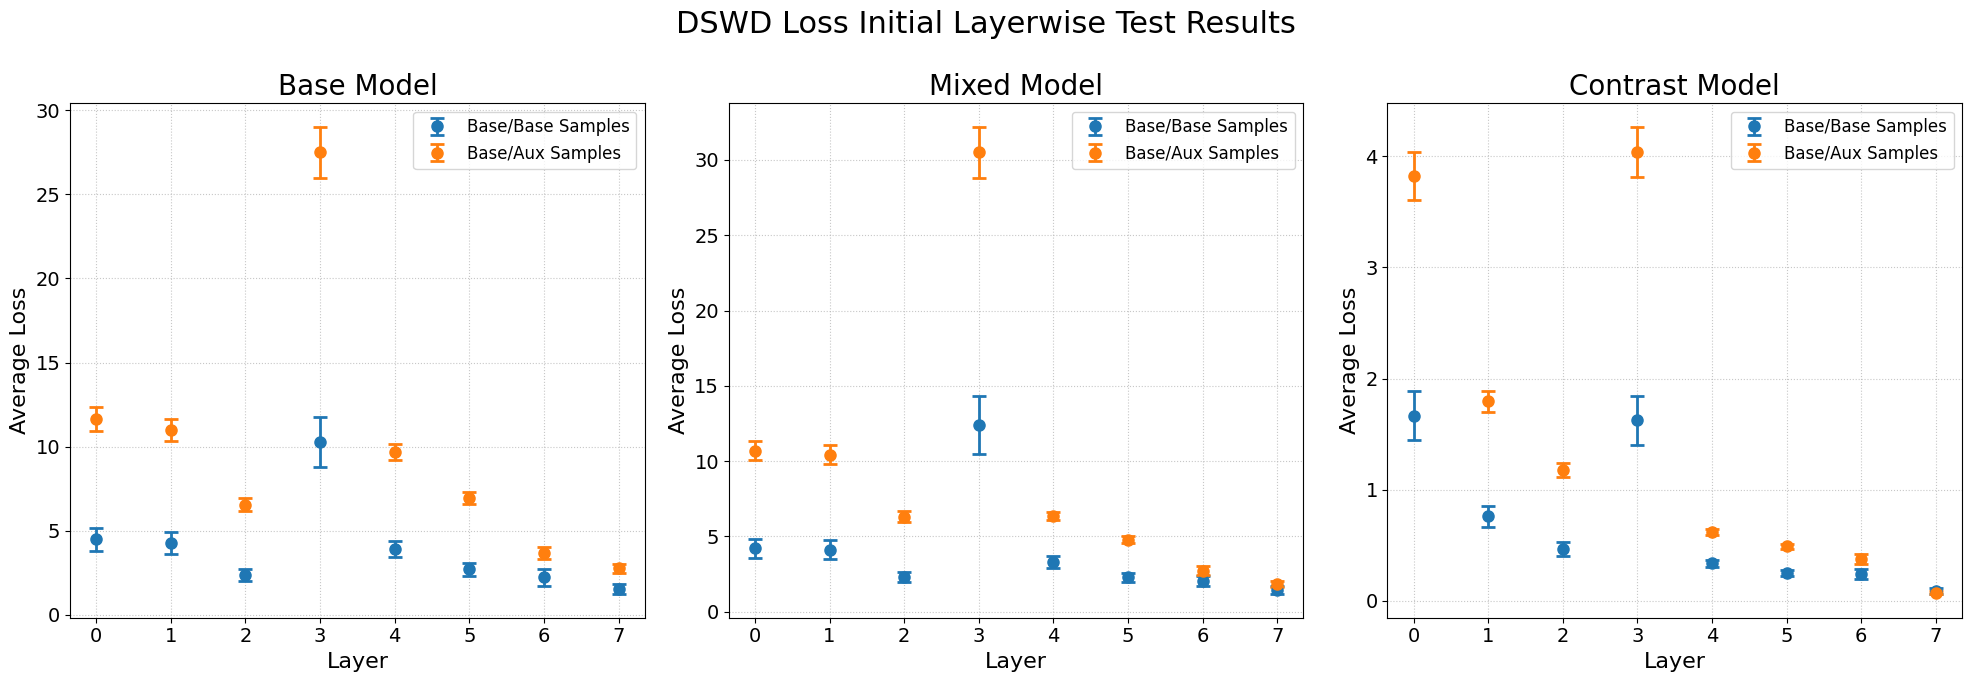

In [22]:
fig, axs = plt.subplots(1, 3, figsize=(20, 7))
fig.suptitle('DSWD Loss Initial Layerwise Test Results', fontsize=22)

categories = ['base', 'mixed', 'contrast']
modes = ['Base/Base', 'Base/Aux']

def dict_to_array(data_dict):
    return np.array([data_dict[str(i)] for i in range(10)])

colors = ['#1f77b4', '#ff7f0e']  # Blue, Orange

for i, cat in enumerate(categories):
    for j in range(2):
        data = loaded[cat][j]
        array = dict_to_array(data).reshape(-1, 9)

        array = np.delete(array, 6, axis=1)

        means = np.mean(array, axis=0)
        stds = np.std(array, axis=0)
        x = range(8)

        axs[i].grid(True, linestyle=":", alpha=.7)

        axs[i].errorbar(x, means, yerr=stds, capsize=5, marker='o', 
                        color=colors[j], ecolor=colors[j], 
                        markersize=8, linewidth=2, capthick=2,
                        label=f'{modes[j]} Samples', linestyle='none')

    # Increase title font size
    axs[i].set_title(f'{cat.capitalize()} Model', fontsize=20)

    # Increase x-label font size
    axs[i].set_xlabel('Layer', fontsize=16)

    # Increase y-label font size
    axs[i].set_ylabel('Average Loss', fontsize=16)

    # Increase tick label font sizes
    axs[i].tick_params(axis='both', which='major', labelsize=14)

    # Add legend
    axs[i].legend(fontsize=12)

plt.tight_layout()
plt.savefig(f'images/DSW_initial_{base}+{aux}_edit.pdf', format="pdf", dpi=300)
plt.show()

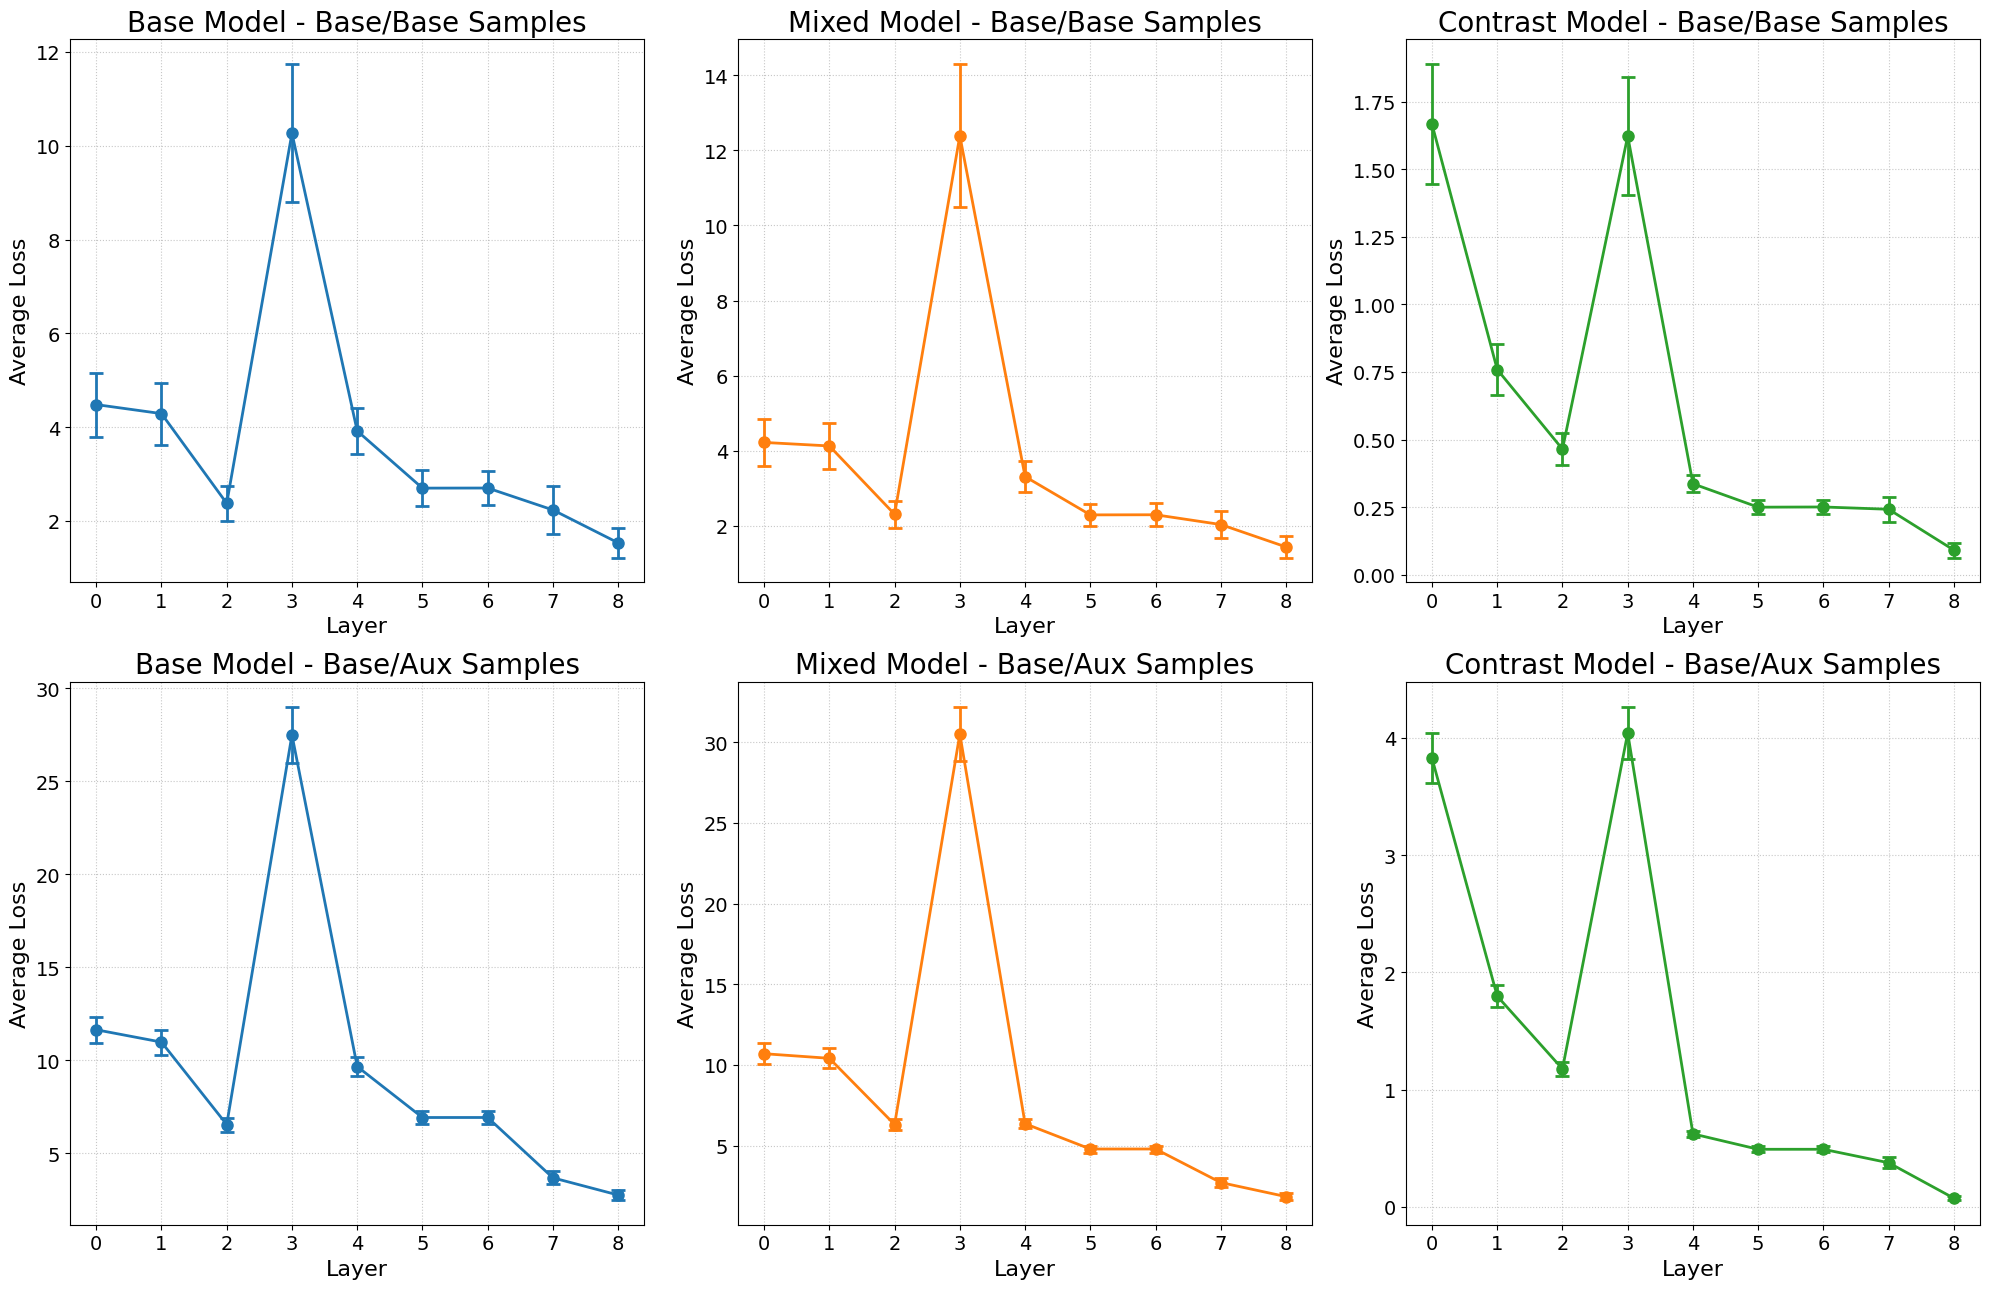

In [57]:
fig, axs = plt.subplots(2, 3, figsize=(20, 13))
fig.suptitle('DSWD Loss Initial Layerwise Test Results', fontsize=22)

categories = ['base', 'mixed', 'contrast']
modes = [0, 1]

def dict_to_array(data_dict):
    return np.array([data_dict[str(i)] for i in range(10)])

for i, cat in enumerate(categories):
    for j in range(2):
        data = dswd_loss_test[cat][j]
        array = dict_to_array(data).reshape(-1, 9)
        means = np.mean(array, axis=0)
        stds = np.std(array, axis=0)
        x = range(9)

        axs[j, i].grid(True, linestyle=":", alpha=.7)
        colors = ['#1f77b4', '#ff7f0e', '#2ca02c']  # Blue, Orange, Green

        axs[j, i].errorbar(x, means, yerr=stds, capsize=5, marker='o', 
                        color=colors[i], ecolor=colors[i], 
                        markersize=8, linewidth=2, capthick=2)

        # Increase title font size
        axs[j, i].set_title(f'{cat.capitalize()} Model - {"Base/Base" if j == 0 else "Base/Aux"} Samples', 
                            fontsize=20)

        # Increase x-label font size
        axs[j, i].set_xlabel('Layer', fontsize=16)

        # Increase y-label font size
        axs[j, i].set_ylabel('Average Loss', fontsize=16)

        # Increase tick label font sizes
        axs[j, i].tick_params(axis='both', which='major', labelsize=14)

        # axs[i, j].set_xticks(x)

# for i, mode in enumerate(modes):
#     for j, category in enumerate(categories):
#         data = dswd_loss_test[category][mode]
        
#         # Get the correct number of x values
#         num_values = len(data['0'])  # Assuming all digits have the same number of values
#         x = range(num_values)
        
#         # Average across all digits
#         avg_data = np.mean([data[str(digit)] for digit in range(10)], axis=0)
#         std_data = np.std([data[str(digit)] for digit in range(10)], axis=0)
        
#         # Plot
#         axs[i, j].errorbar(x, avg_data, yerr=std_data, capsize=5, marker='o')
#         axs[i, j].set_title(f'{category.capitalize()} - {"Val" if mode == 0 else "Test"}')
#         axs[i, j].set_xlabel('Index')
#         axs[i, j].set_ylabel('Average Loss')
#         axs[i, j].set_xticks(x)
plt.tight_layout()
plt.savefig(f'images/DSW_initial_{base}+{aux}.pdf', format="pdf", dpi=300)
plt.show()

### UNET with Base Model

In [17]:
base_model = TinyCNN()
base_model.load_state_dict(torch.load(f"unet_folder/base_classifier_{base}.pt", weights_only=True))
base_model.eval()

unet_base = CustomUNET()
unet_base_optimizer = optim.Adam(
    unet_base.parameters(),
    lr = 3e-4,
    weight_decay = 1e-5
)

unet_base_early_stopper = EarlyStopper(patience=7)
unet_epochs = 50
unet_val_loss = 1e7

for epoch in range(unet_epochs):
    train_loss = unet_run(
        unet_model=unet_base,
        classifier=base_model,
        optimizer=unet_base_optimizer,
        dataloader=train_loader,
        device=DEVICE,
        train=True
    )

    val_loss = unet_run(
        unet_model=unet_base,
        classifier=base_model,
        optimizer=unet_base_optimizer,
        dataloader=val_loader,
        device=DEVICE,
        train=False
    )

    classifier_val_loss, classifier_val_acc = classification_run(
        model=base_model,
        optimizer=None,
        dataloader=val_loader,
        device=DEVICE,
        train=False,
        unet_model=unet_base
    )

    print(f"Epoch {epoch} Loss: {round(train_loss, 4)}, {round(val_loss, 4)}")
    print(f"Epoch {epoch} Loss: {round(classifier_val_loss, 4)}, Acc: {round(classifier_val_acc*100, 2)}\n")

    if unet_val_loss > val_loss:
        unet_val_loss = val_loss
        torch.save(unet_base.state_dict(), f"unet_folder/unet_base_model_{base}+{aux}.pt")

    if unet_base_early_stopper(val_loss):
        break

Epoch 0 Loss: 22.9763, 16.2832
Epoch 0 Loss: 2.8363, Acc: 59.4

Epoch 1 Loss: 12.7543, 18.052
Epoch 1 Loss: 0.4397, Acc: 87.16

Epoch 2 Loss: 9.5564, 16.2977
Epoch 2 Loss: 0.2607, Acc: 92.47

Epoch 3 Loss: 9.0859, 19.5847
Epoch 3 Loss: 0.2648, Acc: 92.57

Epoch 4 Loss: 8.8526, 17.2992
Epoch 4 Loss: 0.2513, Acc: 92.79

Epoch 5 Loss: 8.6557, 14.8701
Epoch 5 Loss: 0.1994, Acc: 93.95

Epoch 6 Loss: 8.5804, 13.1382
Epoch 6 Loss: 0.1952, Acc: 94.09

Epoch 7 Loss: 8.5473, 11.3996
Epoch 7 Loss: 0.1836, Acc: 94.09

Epoch 8 Loss: 8.5356, 12.6732
Epoch 8 Loss: 0.1916, Acc: 94.27

Epoch 9 Loss: 8.7194, 16.1262
Epoch 9 Loss: 0.1934, Acc: 93.83

Epoch 10 Loss: 8.6122, 12.7745
Epoch 10 Loss: 0.1891, Acc: 94.45

Epoch 11 Loss: 8.4764, 15.3777
Epoch 11 Loss: 0.1874, Acc: 94.63

Epoch 12 Loss: 8.3591, 14.321
Epoch 12 Loss: 0.2033, Acc: 93.75

Epoch 13 Loss: 8.4678, 15.959
Epoch 13 Loss: 0.1967, Acc: 94.23

Epoch 14 Loss: 8.3748, 15.8723
Epoch 14 Loss: 0.2007, Acc: 94.11

Epoch 15 Loss: 8.3704, 17.4125
E

### UNET with Mixed Model

In [18]:
mixed_model = TinyCNN()
mixed_model.load_state_dict(torch.load(f"unet_folder/mixed_classifier_{base}+{aux}.pt", weights_only=True))
mixed_model.eval()

unet_mixed = CustomUNET()
unet_mixed_optimizer = optim.Adam(
    unet_mixed.parameters(),
    lr = 3e-4,
    weight_decay = 1e-5
)

unet_mixed_early_stopper = EarlyStopper()
unet_epochs = 20
unet_val_loss = 1e7

for epoch in range(unet_epochs):
    train_loss = unet_run(
        unet_model=unet_mixed,
        classifier=mixed_model,
        optimizer=unet_mixed_optimizer,
        dataloader=train_loader,
        device=DEVICE,
        train=True
    )

    val_loss = unet_run(
        unet_model=unet_mixed,
        classifier=mixed_model,
        optimizer=unet_mixed_optimizer,
        dataloader=val_loader,
        device=DEVICE,
        train=False
    )

    classifier_val_loss, classifier_val_acc = classification_run(
        model=mixed_model,
        optimizer=None,
        dataloader=val_loader,
        device=DEVICE,
        train=False,
        unet_model=unet_mixed
    )

    print(f"Epoch {epoch} Loss: {round(train_loss, 4)}, {round(val_loss, 4)}")
    print(f"Epoch {epoch} Loss: {round(classifier_val_loss, 4)}, Acc: {round(classifier_val_acc*100, 2)}\n")

    if unet_val_loss > val_loss:
        unet_val_loss = val_loss
        torch.save(unet_mixed.state_dict(), f"unet_folder/unet_mixed_model_{base}+{aux}.pt")

    if unet_mixed_early_stopper(val_loss):
        break

Epoch 0 Loss: 30.3696, 22.6709
Epoch 0 Loss: 3.3678, Acc: 53.61

Epoch 1 Loss: 11.7163, 13.7983
Epoch 1 Loss: 0.1455, Acc: 95.63

Epoch 2 Loss: 8.1336, 11.9378
Epoch 2 Loss: 0.1359, Acc: 95.75

Epoch 3 Loss: 7.4861, 11.3781
Epoch 3 Loss: 0.1477, Acc: 94.89

Epoch 4 Loss: 7.2347, 9.5677
Epoch 4 Loss: 0.1322, Acc: 95.75

Epoch 5 Loss: 7.1072, 8.7569
Epoch 5 Loss: 0.1339, Acc: 95.53

Epoch 6 Loss: 6.8864, 9.6962
Epoch 6 Loss: 0.1395, Acc: 95.61

Epoch 7 Loss: 6.8204, 8.9402
Epoch 7 Loss: 0.1377, Acc: 95.23

Epoch 8 Loss: 6.7049, 8.4998
Epoch 8 Loss: 0.1282, Acc: 95.81

Epoch 9 Loss: 6.6885, 7.835
Epoch 9 Loss: 0.146, Acc: 95.29

Epoch 10 Loss: 6.6949, 9.338
Epoch 10 Loss: 0.1369, Acc: 95.43

Epoch 11 Loss: 6.7478, 11.4777
Epoch 11 Loss: 0.1284, Acc: 95.79

Epoch 12 Loss: 6.7188, 9.3936
Epoch 12 Loss: 0.1327, Acc: 95.73

Epoch 13 Loss: 6.5892, 10.3732
Epoch 13 Loss: 0.1238, Acc: 96.09

Epoch 14 Loss: 6.6508, 8.6177
Epoch 14 Loss: 0.1277, Acc: 95.73



### UNET with Contrastive Learning Model

In [19]:
contrast_body = TinyCNN_Headless()
contrast_body.load_state_dict(torch.load(f"unet_folder/contrast_body_{base}+{aux}_{round(best_temp, 2)}.pt", weights_only=True))
contrast_body.eval()
contrast_body.to(DEVICE)

proj_head = torch.nn.Linear(32, 128)
proj_head.load_state_dict(torch.load(f"unet_folder/contrast_proj_{base}+{aux}_{round(best_temp, 2)}.pt", weights_only=True))
proj_head.eval()
proj_head.to(DEVICE)

unet_contrast = CustomUNET()
unet_contrast_optimizer = optim.Adam(
    unet_contrast.parameters(),
    lr = 3e-4,
    weight_decay = 1e-5
)
unet_contrast.to(DEVICE)

unet_contrast_early_stopper = EarlyStopper()
unet_epochs = 20
unet_val_loss = 1e7

for epoch in range(unet_epochs):
    train_loss = unet_run(
        unet_model=unet_contrast,
        classifier=contrast_body,
        optimizer=unet_contrast_optimizer,
        dataloader=train_loader,
        device=DEVICE,
        train=True
    )

    val_loss = unet_run(
        unet_model=unet_contrast,
        classifier=contrast_body,
        optimizer=unet_contrast_optimizer,
        dataloader=val_loader,
        device=DEVICE,
        train=False
    )

    classifier_val_loss = contrastive_run(
        model=contrast_body,
        proj_head=proj_head,
        dataloader=val_loader,
        device=DEVICE,
        unet_model=unet_contrast,
        train=False
    )

    print(f"Epoch {epoch} Loss: {round(train_loss, 4)}, {round(val_loss, 4)}")
    print(f"Epoch {epoch} Loss: {round(classifier_val_loss, 4)}\n")

    if unet_contrast_early_stopper(val_loss) or classifier_val_loss!=classifier_val_loss:
        break

    if unet_val_loss > val_loss:
        unet_val_loss = val_loss
        torch.save(unet_contrast.state_dict(), f"unet_folder/unet_contrast_model_{base}+{aux}.pt")

Epoch 0 Loss: 0.45, 0.4852
Epoch 0 Loss: 2.9531

Epoch 1 Loss: 0.2724, 0.3191
Epoch 1 Loss: 2.9567

Epoch 2 Loss: 0.2398, 0.3236
Epoch 2 Loss: 2.9575

Epoch 3 Loss: 0.2379, 0.2853
Epoch 3 Loss: 2.9548

Epoch 4 Loss: 0.2373, 0.2966
Epoch 4 Loss: 2.9592

Epoch 5 Loss: 0.2367, 0.2939
Epoch 5 Loss: 2.968

Epoch 6 Loss: 0.2368, 0.3115
Epoch 6 Loss: 2.9739

Epoch 7 Loss: 0.235, 0.3528
Epoch 7 Loss: 2.9769

Epoch 8 Loss: 0.2329, 0.2975
Epoch 8 Loss: 2.9851



### Finetune Base Model with Base UNET

In [29]:
base_model = TinyCNN()
base_model.load_state_dict(torch.load(f"unet_folder/base_classifier_{base}.pt", weights_only=True))
base_model.train()
base_model.to(DEVICE)

unet_base = CustomUNET()
unet_base.load_state_dict(torch.load(f"unet_folder/unet_base_model_{base}+{aux}.pt", weights_only=True))
unet_base.eval()
unet_base.to(DEVICE)

base_ft_optimizer = optim.Adam(
    base_model.parameters(),
    lr = 3e-4,
    weight_decay=1e-5
)

base_ft_early_stopper = EarlyStopper()
num_base_ft_epochs = 50
base_val = 1e7

for epoch in range(num_base_ft_epochs):
    classifier_train_loss, classifier_train_acc = classification_run(
        model=base_model,
        optimizer=base_ft_optimizer,
        dataloader=train_loader,
        device=DEVICE,
        train=True,
        unet_model=unet_base
    )

    classifier_val_loss, classifier_val_acc = classification_run(
        model=mixed_model,
        optimizer=None,
        dataloader=val_loader,
        device=DEVICE,
        mode="base_only",
        train=False
    )

    # classifier_val_loss, classifier_val_acc = classification_run(
    #     model=mixed_model,
    #     optimizer=None,
    #     dataloader=val_loader,
    #     device=DEVICE,
    #     mode="base_only",
    #     train=False
    # )

    print(f"Epoch {epoch} Loss: {round(classifier_train_loss, 4)}, Acc: {round(classifier_train_acc*100, 2)}")
    print(f"Epoch {epoch} Loss: {round(classifier_val_loss, 4)}, Acc: {round(classifier_val_acc*100, 2)}\n")

    if base_val > classifier_val_loss:
        base_val = classifier_val_loss
        # torch.save(base_model.state_dict(), f"unet_folder/base_classifier_finetuned_{base}.pt")

    if base_ft_early_stopper(classifier_val_loss):
        break

Epoch 0 Loss: 0.1376, Acc: 95.84
Epoch 0 Loss: 0.1697, Acc: 94.35

Epoch 1 Loss: 0.125, Acc: 96.21
Epoch 1 Loss: 0.1697, Acc: 94.35

Epoch 2 Loss: 0.1224, Acc: 96.26
Epoch 2 Loss: 0.1697, Acc: 94.35

Epoch 3 Loss: 0.1144, Acc: 96.52
Epoch 3 Loss: 0.1697, Acc: 94.35

Epoch 4 Loss: 0.1147, Acc: 96.49
Epoch 4 Loss: 0.1697, Acc: 94.35

Epoch 5 Loss: 0.11, Acc: 96.63
Epoch 5 Loss: 0.1697, Acc: 94.35

Epoch 6 Loss: 0.1039, Acc: 96.75
Epoch 6 Loss: 0.1697, Acc: 94.35

Epoch 7 Loss: 0.1034, Acc: 96.81
Epoch 7 Loss: 0.1697, Acc: 94.35

Epoch 8 Loss: 0.1024, Acc: 96.85
Epoch 8 Loss: 0.1697, Acc: 94.35

Epoch 9 Loss: 0.0989, Acc: 96.99
Epoch 9 Loss: 0.1697, Acc: 94.35

Epoch 10 Loss: 0.0944, Acc: 97.15
Epoch 10 Loss: 0.1697, Acc: 94.35

Epoch 11 Loss: 0.0917, Acc: 97.12
Epoch 11 Loss: 0.1697, Acc: 94.35

Epoch 12 Loss: 0.0906, Acc: 97.21
Epoch 12 Loss: 0.1697, Acc: 94.35

Epoch 13 Loss: 0.0857, Acc: 97.26
Epoch 13 Loss: 0.1697, Acc: 94.35

Epoch 14 Loss: 0.085, Acc: 97.34
Epoch 14 Loss: 0.1697, A

### Finetune Mixed Model with Mixed UNET

In [ ]:
mixed_model = TinyCNN()
mixed_model.load_state_dict(torch.load(f"unet_folder/mixed_classifier_{base}+{aux}.pt", weights_only=True))
mixed_model.train()
mixed_model.to(DEVICE)

unet_mixed = CustomUNET()
unet_mixed.load_state_dict(torch.load(f"unet_folder/unet_mixed_model_{base}+{aux}.pt", weights_only=True))
unet_mixed.eval()
unet_mixed.to(DEVICE)

mixed_ft_optimizer = optim.Adam(
    mixed_model.parameters(),
    lr = 1e-4,
    weight_decay=1e-5
)

mixed_ft_early_stopper = EarlyStopper()
num_base_ft_epochs = 50
mixed_val = 1e7

for epoch in range(num_base_ft_epochs):
    classifier_train_loss, classifier_train_acc = classification_run(
        model=mixed_model,
        optimizer=mixed_ft_optimizer,
        dataloader=train_loader,
        device=DEVICE,
        train=True,
        unet_model=unet_mixed
    )

    classifier_val_loss, classifier_val_acc = classification_run(
        model=mixed_model,
        optimizer=None,
        dataloader=val_loader,
        device=DEVICE,
        mode="base_only",
        train=False
    )

    print(f"Epoch {epoch} Loss: {round(classifier_train_loss, 4)}, Acc: {round(classifier_train_acc*100, 2)}")
    print(f"Epoch {epoch} Loss: {round(classifier_val_loss, 4)}, Acc: {round(classifier_val_acc*100, 2)}\n")

    if mixed_val > classifier_val_loss:
        mixed_val = classifier_val_loss
        torch.save(mixed_model.state_dict(), f"unet_folder/mixed_classifier_finetuned_{base}+{aux}.pt")

    if mixed_ft_early_stopper(classifier_val_loss):
        break

Epoch 0 Loss: 0.1232, Acc: 96.16
Epoch 0 Loss: 0.1697, Acc: 94.35

Epoch 1 Loss: 0.1228, Acc: 96.09
Epoch 1 Loss: 0.1697, Acc: 94.35

Epoch 2 Loss: 0.1177, Acc: 96.22
Epoch 2 Loss: 0.1697, Acc: 94.35

Epoch 3 Loss: 0.1225, Acc: 96.11
Epoch 3 Loss: 0.1697, Acc: 94.35

Epoch 4 Loss: 0.1212, Acc: 96.17
Epoch 4 Loss: 0.1697, Acc: 94.35

Epoch 5 Loss: 0.1214, Acc: 96.21
Epoch 5 Loss: 0.1697, Acc: 94.35

Epoch 6 Loss: 0.1163, Acc: 96.32
Epoch 6 Loss: 0.1697, Acc: 94.35

Epoch 7 Loss: 0.1238, Acc: 96.09
Epoch 7 Loss: 0.1697, Acc: 94.35

Epoch 8 Loss: 0.1222, Acc: 96.2
Epoch 8 Loss: 0.1697, Acc: 94.35

Epoch 9 Loss: 0.1195, Acc: 96.21
Epoch 9 Loss: 0.1697, Acc: 94.35

Epoch 10 Loss: 0.1164, Acc: 96.31
Epoch 10 Loss: 0.1697, Acc: 94.35

Epoch 11 Loss: 0.1218, Acc: 96.15
Epoch 11 Loss: 0.1697, Acc: 94.35

Epoch 12 Loss: 0.1181, Acc: 96.25
Epoch 12 Loss: 0.1697, Acc: 94.35

Epoch 13 Loss: 0.1208, Acc: 96.24
Epoch 13 Loss: 0.1697, Acc: 94.35

Epoch 14 Loss: 0.1186, Acc: 96.24
Epoch 14 Loss: 0.1697

### Finetune Contrast Model with Contrast UNET

#### Retrain Body

In [ ]:
contrast_body = TinyCNN_Headless()
contrast_body.load_state_dict(torch.load(f"unet_folder/contrast_body_{base}+{aux}_{round(best_temp, 2)}.pt", weights_only=True))
contrast_body.train()
contrast_body.to(DEVICE)

proj_head = torch.nn.Linear(32, 128)
proj_head.load_state_dict(torch.load(f"unet_folder/contrast_proj_{base}+{aux}_{round(best_temp, 2)}.pt", weights_only=True))
proj_head.train()
proj_head.to(DEVICE)

unet_contrast = CustomUNET()
unet_contrast.load_state_dict(torch.load(f"unet_folder/unet_contrast_model_{base}+{aux}.pt", weights_only=True))
unet_contrast.eval()
unet_contrast.to(DEVICE)

contrast_ft_optimizer = optim.Adam(
    list(contrast_body.parameters()) + list(proj_head.parameters()),
    lr=1e-4, 
    weight_decay=1e-5
)

contrast_ft_early_stopper = EarlyStopper()
num_base_ft_epochs = 50
contrast_val = 1e7

unet_contrast_early_stopper = EarlyStopper()
contrast_epochs = 50
unet_val_loss = 1e7

for epoch in range(contrast_epochs):
    classifier_train_loss = contrastive_run(
        model=contrast_body,
        proj_head=proj_head,
        optimizer=contrast_ft_optimizer,
        dataloader=train_loader,
        device=DEVICE,
        unet_model=unet_contrast,
        train=True
    )

    classifier_val_loss = contrastive_run(
        model=contrast_body,
        proj_head=proj_head,
        optimizer=None,
        dataloader=val_loader,
        device=DEVICE,
        unet_model=unet_contrast,
        train=False
    )

    print(f"Epoch {epoch} Loss: {round(classifier_train_loss, 4)}, {round(classifier_val_loss, 4)}")

    if contrast_val > classifier_val_loss:
        contrast_val = classifier_val_loss
        torch.save(contrast_body.state_dict(), f"unet_folder/contrast_body_finetuned_{base}+{aux}.pt")

    if unet_contrast_early_stopper(classifier_val_loss):
        break

Epoch 0 Loss: 2.775, 2.8211
Epoch 1 Loss: 2.719, 2.8187
Epoch 2 Loss: 2.7073, 2.7989
Epoch 3 Loss: 2.6962, 2.7817
Epoch 4 Loss: 2.6895, 2.7916
Epoch 5 Loss: 2.6806, 2.7931
Epoch 6 Loss: 2.6678, 2.7935
Epoch 7 Loss: 2.6652, 2.7859
Epoch 8 Loss: 2.6671, 2.7992


### Retrain Head

In [23]:
contrast_body = TinyCNN_Headless()
contrast_body.load_state_dict(torch.load(f"unet_folder/contrast_body_finetuned_{base}+{aux}.pt", weights_only=True))
contrast_body.eval()

class_head = TinyCNN_Head()

wrapped_model = WrapperModelTrainHead(
    body = contrast_body,
    head = class_head
)
wrapped_model.to(DEVICE)
optimizer = optim.Adam(
    wrapped_model.head.parameters(),
    lr = 1e-3,
    weight_decay = 1e-5
)

contrast_early_stopper = EarlyStopper()

unet_contrast = CustomUNET()
unet_contrast.load_state_dict(torch.load(f"unet_folder/unet_contrast_model_{base}+{aux}.pt", weights_only=True))
unet_contrast.eval()
unet_contrast.to(DEVICE)

num_class_epochs = 50
contrast_val = 1e7

for epoch in range(num_class_epochs):
    train_loss, train_acc = classification_run(
        model=wrapped_model,
        optimizer=optimizer,
        dataloader=train_loader,
        mode="base_only",
        unet_model=unet_contrast,
        device=DEVICE,
    )

    val_loss, val_acc = classification_run(
        model=wrapped_model,
        optimizer=optimizer,
        dataloader=val_loader,
        device=DEVICE,
        mode="base_only",
        unet_model=unet_contrast,
        train=False
    )

    print(f"Epoch {epoch}:", round(train_loss, 4), round(train_acc*100, 2), round(val_loss, 4), round(val_acc*100, 2))

    if contrast_early_stopper(val_loss):
        break

    if val_loss < contrast_val:
        contrast_val = val_loss
        torch.save(wrapped_model.state_dict(), f"unet_folder/contrast_classifier_finetuned_{base}+{aux}.pt")

Epoch 0: 2.0468 63.01 1.6218 93.23
Epoch 1: 1.0835 96.28 0.6495 96.31
Epoch 2: 0.4532 97.24 0.328 96.35
Epoch 3: 0.2565 97.74 0.2325 96.07
Epoch 4: 0.1817 97.93 0.1857 96.25
Epoch 5: 0.1495 97.94 0.1676 96.35
Epoch 6: 0.1248 98.15 0.1608 96.33
Epoch 7: 0.1145 98.09 0.1362 96.55
Epoch 8: 0.1041 98.04 0.1387 96.51
Epoch 9: 0.0969 98.14 0.1261 96.53
Epoch 10: 0.0933 98.07 0.1314 96.67
Epoch 11: 0.085 98.27 0.1289 96.41
Epoch 12: 0.0883 98.1 0.1296 96.55
Epoch 13: 0.0843 98.25 0.1219 96.47
Epoch 14: 0.0786 98.25 0.1194 96.79
Epoch 15: 0.0751 98.35 0.1148 96.67
Epoch 16: 0.0816 98.12 0.1185 96.63
Epoch 17: 0.0773 98.12 0.1333 96.31
Epoch 18: 0.0715 98.29 0.1315 96.55
Epoch 19: 0.0758 98.21 0.1212 96.55
Epoch 20: 0.0776 98.2 0.1206 96.73


### Compare Accuracies Between Models

In [24]:
base_model = TinyCNN()
base_model.load_state_dict(torch.load(f"unet_folder/base_classifier_finetuned_{base}.pt", weights_only=True))
base_model.to(DEVICE)
base_loss, base_acc = classification_run(
    model=base_model,
    optimizer=optimizer,
    dataloader=val_loader,
    device=DEVICE,
    mode="base_only",
    train=False
)

mixed_model = TinyCNN()
mixed_model.load_state_dict(torch.load(f"unet_folder/mixed_classifier_finetuned_{base}+{aux}.pt", weights_only=True))
mixed_model.to(DEVICE)
mixed_loss, mixed_acc = classification_run(
    model=mixed_model,
    optimizer=optimizer,
    dataloader=val_loader,
    device=DEVICE,
    mode="base_only",
    train=False
)

contrast_body = TinyCNN_Headless()
contrast_head = TinyCNN_Head()

contrast_model = WrapperModelTrainHead(
    body=contrast_body,
    head=contrast_head
)
contrast_model.load_state_dict(torch.load(f"unet_folder/contrast_classifier_finetuned_{base}+{aux}.pt", weights_only=True))
contrast_model.to(DEVICE)

contrast_loss, contrast_acc = classification_run(
    model=contrast_model,
    optimizer=optimizer,
    dataloader=val_loader,
    device=DEVICE,
    mode="base_only",
    train=False
)

print(f"Base: {round(base_loss, 4)}, {round(base_acc*100, 2)}")
print(f"Base + Aux: {round(mixed_loss, 4)}, {round(mixed_acc*100, 2)}")
print(f"Base + Aux: {round(contrast_loss, 4)}, {round(contrast_acc*100, 2)}")

Base: 0.1504, 95.51
Base + Aux: 0.1697, 94.35
Base + Aux: 0.144, 95.67


### Plot Latent Space Representations

In [25]:
base_model = TinyCNN()
base_model.load_state_dict(torch.load(f"unet_folder/base_classifier_finetuned_{base}.pt", weights_only=True))
base_model.eval()

unet_base = CustomUNET()
unet_base.load_state_dict(torch.load(f"unet_folder/unet_base_model_{base}+{aux}.pt", weights_only=True))
unet_base.eval()

mixed_model = TinyCNN()
mixed_model.load_state_dict(torch.load(f"unet_folder/mixed_classifier_finetuned_{base}+{aux}.pt", weights_only=True))
mixed_model.eval()

unet_mixed = CustomUNET()
unet_mixed.load_state_dict(torch.load(f"unet_folder/unet_mixed_model_{base}+{aux}.pt", weights_only=True))
unet_mixed.eval()

contrast_body = TinyCNN_Headless()
contrast_head = TinyCNN_Head()

contrast_model = WrapperModelTrainHead(
    body=contrast_body,
    head=contrast_head
)

contrast_model.load_state_dict(torch.load(f"unet_folder/contrast_classifier_finetuned_{base}+{aux}.pt", weights_only=True))
contrast_model.eval()

unet_contrast = CustomUNET()
unet_contrast.load_state_dict(torch.load(f"unet_folder/unet_contrast_model_{base}+{aux}.pt", weights_only=True))
unet_contrast.eval()

contrast_model.to(DEVICE)
base_model.to(DEVICE)
mixed_model.to(DEVICE)

unet_contrast.to(DEVICE)
unet_base.to(DEVICE)
unet_mixed.to(DEVICE)

base_embeds_base = np.zeros((len(test_dataset), 32))
base_embeds_aux = np.zeros((len(test_dataset), 32))
mixed_embeds_base = np.zeros((len(test_dataset), 32))
mixed_embeds_aux = np.zeros((len(test_dataset), 32))
contrast_embeds_base = np.zeros((len(test_dataset), 32))
contrast_embeds_aux = np.zeros((len(test_dataset), 32))
labels = np.zeros(len(test_dataset))

test_loader.dataset.unique_sources = True
bs = val_loader.batch_size

for i, (x,y,z) in enumerate(test_loader):
    x = x.to(DEVICE)
    y = y.to(DEVICE)
    with torch.no_grad():
        y_base = unet_base(y)
        y_mixed = unet_mixed(y)
        y_contrast = unet_contrast(y)

        base_outputs_base = base_model(x)[9].cpu().numpy()
        base_outputs_aux = base_model(y_base)[9].cpu().numpy()
        mixed_outputs_base = mixed_model(x)[9].cpu().numpy()
        mixed_outputs_aux = mixed_model(y_mixed)[9].cpu().numpy()
        contrast_outputs_base = contrast_model(x)[9].cpu().numpy()
        contrast_outputs_aux = contrast_model(y_contrast)[9].cpu().numpy()

        base_embeds_base[i*bs:i*bs+bs] = base_outputs_base
        base_embeds_aux[i*bs:i*bs+bs] = base_outputs_aux
        mixed_embeds_base[i*bs:i*bs+bs] = mixed_outputs_base
        mixed_embeds_aux[i*bs:i*bs+bs] = mixed_outputs_aux
        contrast_embeds_base[i*bs:i*bs+bs] = contrast_outputs_base
        contrast_embeds_aux[i*bs:i*bs+bs] = contrast_outputs_aux
        labels[i*bs:i*bs+bs] = z.cpu()


C:\Users\Justin\AppData\Local\Temp\ipykernel_32724\3664967421.py:54: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  tab20 = plt.cm.get_cmap('tab20')
C:\Users\Justin\AppData\Local\Temp\ipykernel_32724\3664967421.py:89: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  tab20 = plt.cm.get_cmap('tab20')


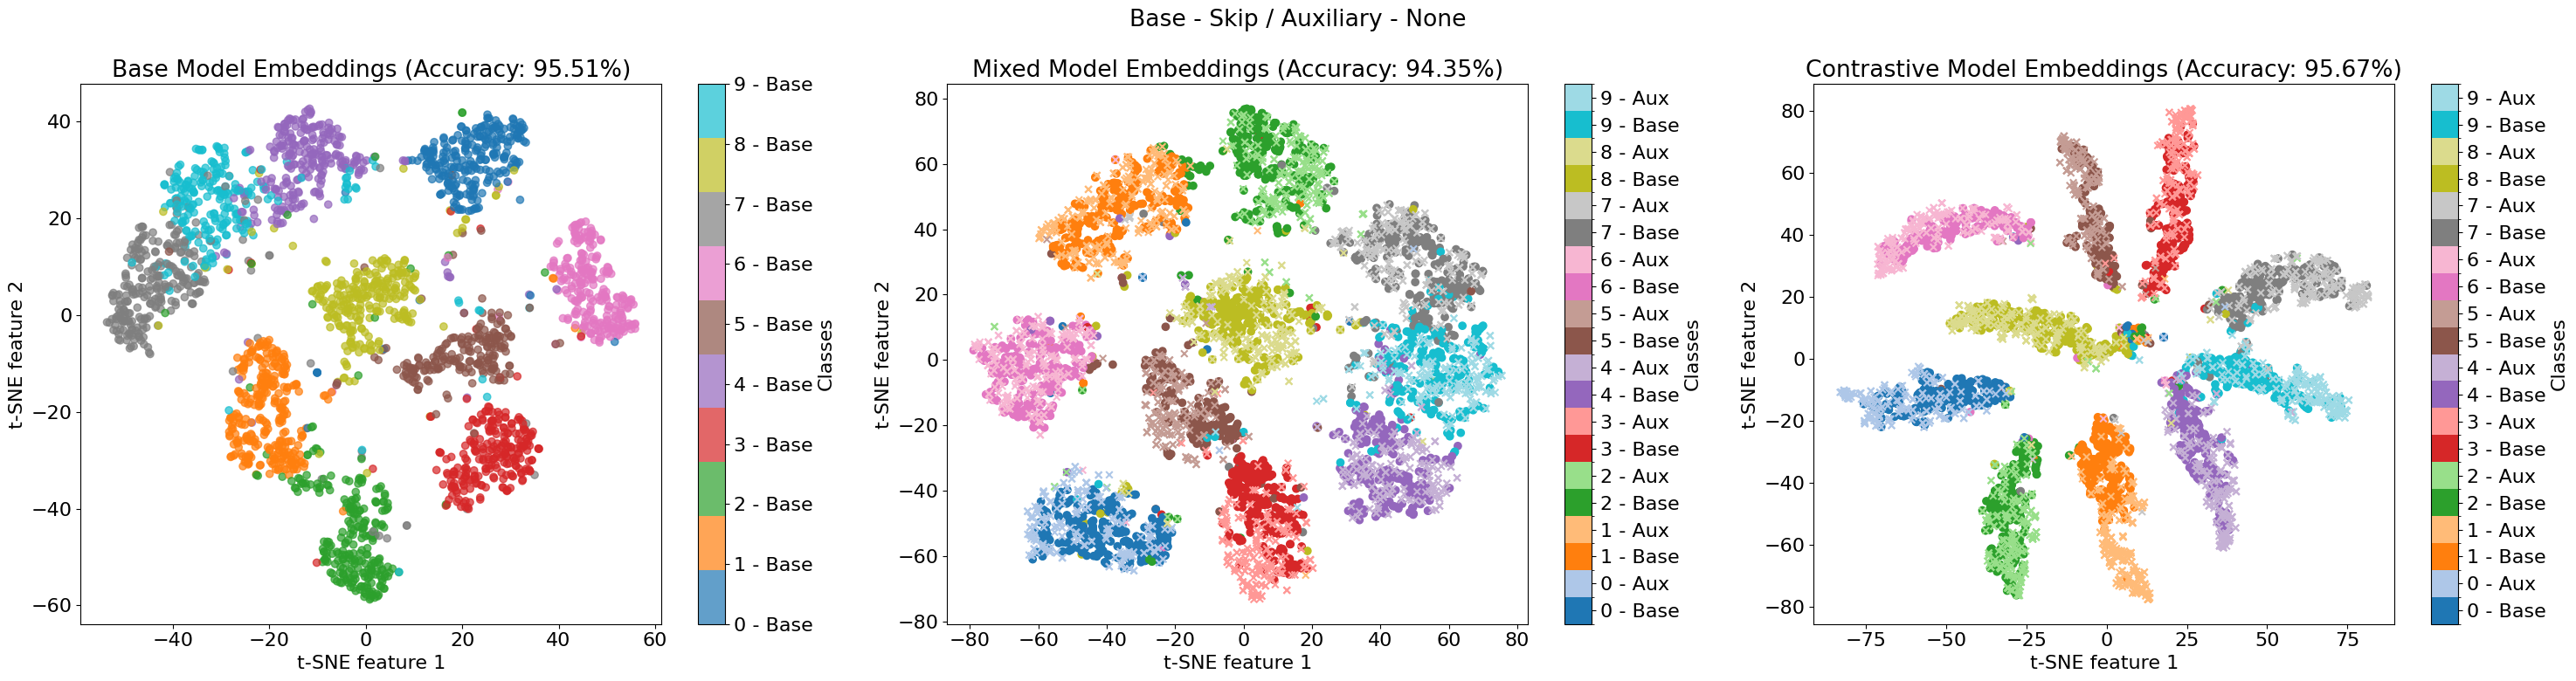

In [26]:
base_labels = np.concatenate((labels*2, labels*2+1))
base_embeds = np.concatenate((base_embeds_base, base_embeds_aux))

mixed_labels = np.concatenate((labels*2, labels*2+1))
mixed_embeds = np.concatenate((mixed_embeds_base, mixed_embeds_aux))

contrast_labels = np.concatenate((labels*2, labels*2+1))
contrast_embeds = np.concatenate((contrast_embeds_base, contrast_embeds_aux))

import numpy as np
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import matplotlib.colors as mcolors

plt.rcParams['font.size'] = 16

# Perform t-SNE for all three embedding sets
tsne = TSNE(n_components=2, random_state=42)
base_tsne = tsne.fit_transform(base_embeds_base)
mixed_tsne = tsne.fit_transform(mixed_embeds)
contrast_tsne = tsne.fit_transform(contrast_embeds)

# Convert labels to numpy if it's a torch tensor
if isinstance(labels, torch.Tensor):
    labels = labels.numpy()

# Create three subplots side by side
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(30, 8))

# Plot for base embeddings
scatter1 = ax1.scatter(base_tsne[:, 0], base_tsne[:, 1], c=labels, cmap='tab10', alpha=.7)
ax1.set_title(f'Base Model Embeddings (Accuracy: {round(base_acc*100, 2)}%)')
ax1.set_xlabel('t-SNE feature 1')
ax1.set_ylabel('t-SNE feature 2')
cbar = fig.colorbar(scatter1, ax=ax1)
ticks = np.arange(0, 10)
c_labels = [ 
    "0 - Base",
    "1 - Base",
    "2 - Base",
    "3 - Base",
    "4 - Base",
    "5 - Base",
    "6 - Base",
    "7 - Base",
    "8 - Base",
    "9 - Base",
]
cbar.set_ticks(ticks)
cbar.set_ticklabels(c_labels)
cbar.set_label("Classes")

tab20 = plt.cm.get_cmap('tab20')
color_dict = {i: tab20(i/20) for i in range(20)}

scatter2a = ax2.scatter(mixed_tsne[:len(mixed_tsne)//2, 0], mixed_tsne[:len(mixed_tsne)//2, 1], c=[color_dict[label] for label in mixed_labels[:len(mixed_tsne)//2]])
scatter2b = ax2.scatter(mixed_tsne[len(mixed_tsne)//2:, 0], mixed_tsne[len(mixed_tsne)//2:, 1], c=[color_dict[label] for label in mixed_labels[len(mixed_tsne)//2:]], marker="x", s=30)
ax2.set_title(f'Mixed Model Embeddings (Accuracy: {round(mixed_acc*100, 2)}%)')
ax2.set_xlabel('t-SNE feature 1')
ax2.set_ylabel('t-SNE feature 2')
colors = [color_dict[i] for i in range(20)]
cmap = mcolors.ListedColormap(colors)
bounds = np.arange(21)
norm = mcolors.BoundaryNorm(bounds, cmap.N)

# Create the colorbar
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])
cbar = fig.colorbar(sm, ax=ax2, ticks=np.arange(0.5, 20))

c_labels = [
    "0 - Base", "0 - Aux",
    "1 - Base", "1 - Aux",
    "2 - Base", "2 - Aux",
    "3 - Base", "3 - Aux",
    "4 - Base", "4 - Aux",
    "5 - Base", "5 - Aux",
    "6 - Base", "6 - Aux",
    "7 - Base", "7 - Aux",
    "8 - Base", "8 - Aux",
    "9 - Base", "9 - Aux",
]
cbar.set_ticklabels(c_labels)
cbar.set_label("Classes")


# Plot for contrast embeddings
tab20 = plt.cm.get_cmap('tab20')
color_dict = {i: tab20(i/20) for i in range(20)}

scatter3a = ax3.scatter(contrast_tsne[:len(contrast_tsne)//2, 0], contrast_tsne[:len(contrast_tsne)//2, 1], c=[color_dict[label] for label in contrast_labels[:len(contrast_tsne)//2]])
scatter3b = ax3.scatter(contrast_tsne[len(contrast_tsne)//2:, 0], contrast_tsne[len(contrast_tsne)//2:, 1], c=[color_dict[label] for label in contrast_labels[len(contrast_tsne)//2:]], marker="x", s=30)
ax3.set_title(f'Contrastive Model Embeddings (Accuracy: {round(contrast_acc*100, 2)}%)')
ax3.set_xlabel('t-SNE feature 1')
ax3.set_ylabel('t-SNE feature 2')
colors = [color_dict[i] for i in range(20)]
cmap = mcolors.ListedColormap(colors)
bounds = np.arange(21)
norm = mcolors.BoundaryNorm(bounds, cmap.N)

# Create the colorbar
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])
cbar = fig.colorbar(sm, ax=ax3, ticks=np.arange(0.5, 20))

c_labels = [
    "0 - Base", "0 - Aux",
    "1 - Base", "1 - Aux",
    "2 - Base", "2 - Aux",
    "3 - Base", "3 - Aux",
    "4 - Base", "4 - Aux",
    "5 - Base", "5 - Aux",
    "6 - Base", "6 - Aux",
    "7 - Base", "7 - Aux",
    "8 - Base", "8 - Aux",
    "9 - Base", "9 - Aux",
]
cbar.set_ticklabels(c_labels)
cbar.set_label("Classes")

fig.suptitle(f"Base - {base.capitalize()} / Auxiliary - {aux.capitalize()}")

plt.tight_layout()
plt.savefig(f'images/tsne_2d_{base}+{aux}_unet_single.pdf', format="pdf", dpi=300)
plt.show()

In [ ]:
base_model = TinyCNN()
base_model.load_state_dict(torch.load(f"unet_folder/base_classifier_finetuned_{base}.pt", weights_only=True))
base_model.eval()

unet_base = CustomUNET()
unet_base.load_state_dict(torch.load(f"unet_folder/unet_base_model_{base}+{aux}.pt", weights_only=True))
unet_base.eval()

mixed_model = TinyCNN()
mixed_model.load_state_dict(torch.load(f"unet_folder/mixed_classifier_finetuned_{base}+{aux}.pt", weights_only=True))
mixed_model.eval()

unet_mixed = CustomUNET()
unet_mixed.load_state_dict(torch.load(f"unet_folder/unet_mixed_model_{base}+{aux}.pt", weights_only=True))
unet_mixed.eval()

contrast_body = TinyCNN_Headless()
contrast_head = TinyCNN_Head()

contrast_model = WrapperModelTrainHead(
    body=contrast_body,
    head=contrast_head
)

contrast_model.load_state_dict(torch.load(f"unet_folder/contrast_classifier_finetuned_{base}+{aux}.pt", weights_only=True))
contrast_model.eval()

unet_contrast = CustomUNET()
unet_contrast.load_state_dict(torch.load(f"unet_folder/unet_contrast_model_{base}+{aux}.pt", weights_only=True))
unet_contrast.eval()

contrast_model.to(DEVICE)
base_model.to(DEVICE)
mixed_model.to(DEVICE)

unet_contrast.to(DEVICE)
unet_base.to(DEVICE)
unet_mixed.to(DEVICE)

In [ ]:
dswd_loss_test = {
    "base": [],
    "mixed": [],
    "contrast": [],
}
# 2 - base or mixed

networks = {
    "base": [base_model, unet_base],
    "mixed": [mixed_model, unet_mixed],
    "contrast": [contrast_model, unet_contrast],
}

for i, network in enumerate(networks.keys()):
    print(f"Starting network {network} : {i+1}/{len(networks)}")

    dswd_loss_mixed, class_hist = run_dswd_all_classes(
        model=networks[network][0],
        dataloader=test_loader,
        layers=8,
        device=DEVICE,
        base_only=False,
        unet_model=networks[network][1],
        num_projections=256
    )
    dswd_loss_test[network].append(dswd_loss_mixed)

# with open(r"C:\Users\Justin\Downloads\data_post.pkl", "wb") as f:
#     pickle.dump(dswd_loss_test, f)

Starting network base : 1/3
Class 0 Size: 192 (3 batches)
Class 0 Losses: [[ 9.3738842   9.06019688  5.04025507 26.13435936 12.02505207  7.57040262
   7.56971121  3.63817239  2.96036673]
 [10.60193825 10.25515366  5.84294748 29.79948425 13.61197281  8.7675848
   8.7669878   4.69196558  3.82860589]
 [11.84945869 11.49800301  6.51493931 30.95261955 14.55895042  9.34229374
   9.34340191  4.85445213  4.04001713]
 [10.29809761  9.98297977  5.45258331 26.47915459 12.34443188  7.7715683
   7.77125311  3.72834468  2.97787547]
 [10.76514626 10.33978844  5.80453014 26.16982079 12.46601772  7.8926897
   7.89392614  3.77409959  3.25491953]
 [12.04433155 11.60246181  6.63461399 30.90650368 14.66484833  9.45875168
   9.4603653   4.64569759  4.42829275]
 [ 9.70777988  9.41780472  5.37548733 26.16337585 12.29710865  7.98480797
   7.98501301  3.98159695  3.44048262]
 [11.22206783 10.85692501  5.94722366 29.38401031 13.73520947  8.65681171
   8.6574955   4.93203259  4.3291769 ]
 [11.29211712 10.91516018

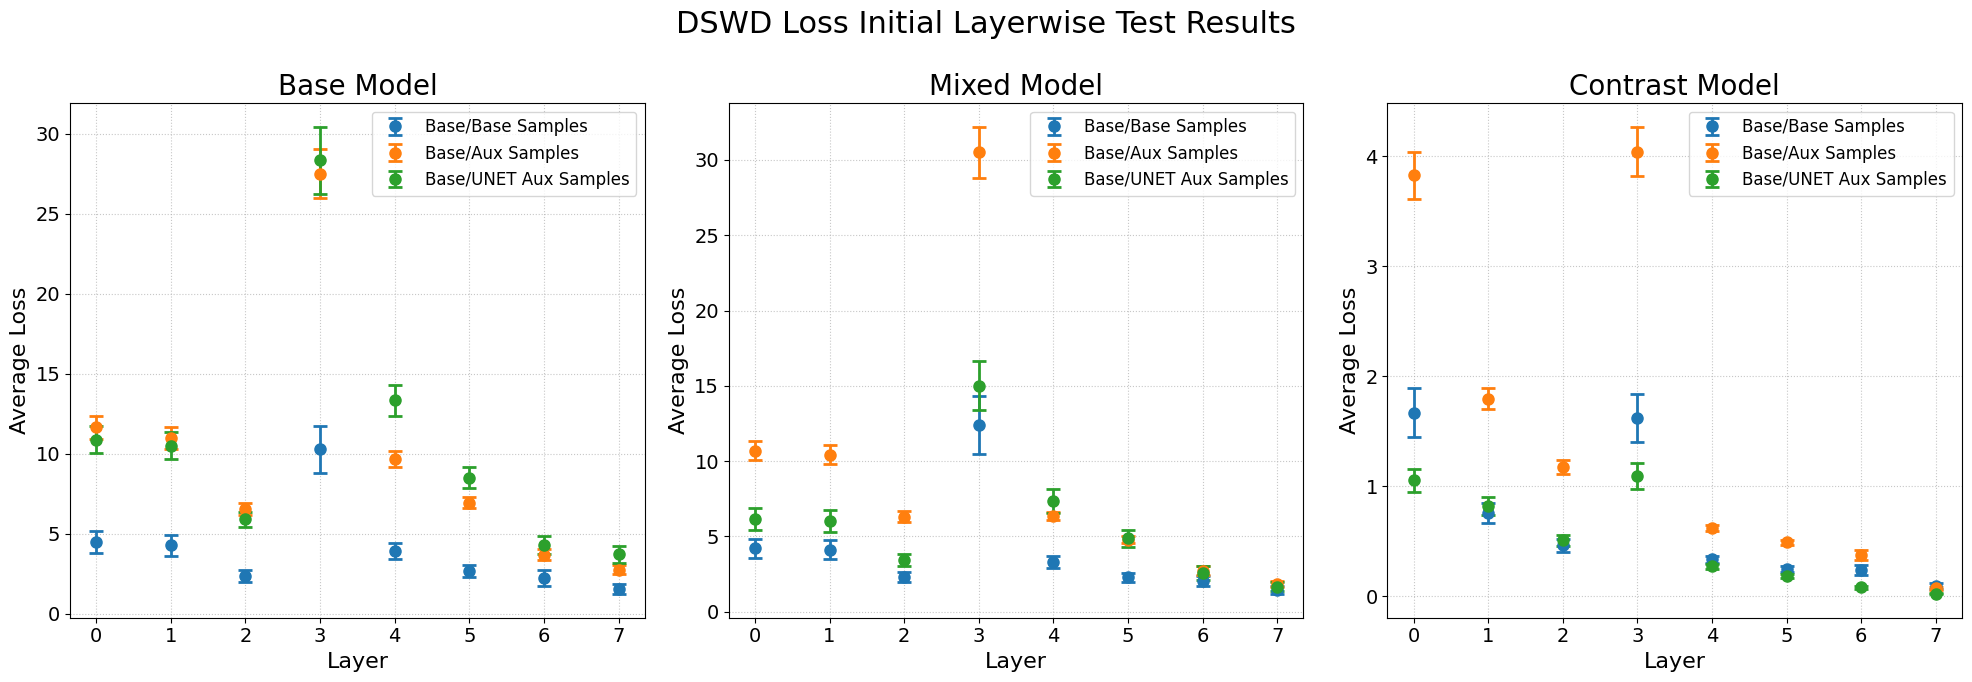

In [33]:
with open(r"C:\Users\Justin\Downloads\data.pkl", "rb") as f:
    loaded_first = pickle.load(f)

with open(r"C:\Users\Justin\Downloads\data_post.pkl", "rb") as f:
    loaded_second = pickle.load(f)

fig, axs = plt.subplots(1, 3, figsize=(20, 7))
fig.suptitle('DSWD Loss Initial Layerwise Test Results', fontsize=22)

categories = ['base', 'mixed', 'contrast']
modes = ['Base/Base', 'Base/Aux', 'Base/UNET Aux']

def dict_to_array(data_dict):
    return np.array([data_dict[str(i)] for i in range(10)])

colors = ['#1f77b4', '#ff7f0e', '#2ca02c']  # Blue, Orange

for i, cat in enumerate(categories):
    for j in range(3):
        if j < 2:
            data = loaded_first[cat][j]
        else:
            data = loaded_second[cat][0]

        array = dict_to_array(data).reshape(-1, 9)

        array = np.delete(array, 6, axis=1)

        means = np.mean(array, axis=0)
        stds = np.std(array, axis=0)
        x = range(8)

        axs[i].grid(True, linestyle=":", alpha=.7)

        axs[i].errorbar(x, means, yerr=stds, capsize=5, marker='o', 
                        color=colors[j], ecolor=colors[j], 
                        markersize=8, linewidth=2, capthick=2,
                        label=f'{modes[j]} Samples', linestyle='none')

    # Increase title font size
    axs[i].set_title(f'{cat.capitalize()} Model', fontsize=20)

    # Increase x-label font size
    axs[i].set_xlabel('Layer', fontsize=16)

    # Increase y-label font size
    axs[i].set_ylabel('Average Loss', fontsize=16)

    # Increase tick label font sizes
    axs[i].tick_params(axis='both', which='major', labelsize=14)

    # Add legend
    axs[i].legend(fontsize=12)

plt.tight_layout()
plt.savefig(f'images/DSW_unet_none+skip.pdf', format="pdf", dpi=300)
plt.show()